In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
p_nw = []
p_net_nw = []
loss_nw = []
loss_net_nw = []
bool_nw = []

for network_name in ["DAGMA_thresholdAdaptive"]:
    
    # measurements across 10 random sample split
    p_rs = []
    p_net_rs = []
    loss_rs = []
    loss_net_rs = []
    bool_rs = []
    
    for rs in range(10):
        # read data
        X_train = pd.read_csv("../../result/input_perturb_phyloP/%d/X_train_stratified" % rs, sep="\t", index_col=0).values
        X_valid = pd.read_csv("../../result/input_perturb_phyloP/%d/X_valid_stratified" % rs, sep="\t", index_col=0).values
        X_test = pd.read_csv("../../result/input_perturb_phyloP/%d/X_test_stratified" % rs, sep="\t", index_col=0).values
        Y_test = pd.read_csv("../../result/input_perturb_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).values.reshape(-1)
        Y_test_gene = pd.read_csv("../../result/input_perturb_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).index

        test_mask = np.concatenate([[False] * len(X_train), [False] * len(X_valid), [True] * len(X_test)])

        # mask of whether a test node is in the DAGMA graph
        dag = pd.read_csv("../../result/network_perturb_phyloP/DAGMA_thresholdAdaptive.tsv", sep="\t", header=None)
        id2genes = pd.read_csv("../../result/network_perturb_phyloP/valid_genes", sep="\t").set_index("ID")['genes'].to_dict()
        dag[0] = dag[0].map(id2genes)
        dag[1] = dag[1].map(id2genes)
        dag_genes = list(set.union(set(dag[0]), set(dag[1])))
        test_inDAG = Y_test_gene.isin(dag_genes)

        # measurements across 10 random init repeats
        p_rep = []
        p_net_rep = []
        loss_rep = []
        loss_net_rep = []

        for rep in range(10):
            prefix = "../../result/model_perturb_phyloP/%s/%d/model%d" % (network_name, rs, rep)
            with open(prefix+".para", "rb") as f:
                best_params, X1, out, loss1, loss2 = pickle.load(f)
            Y_pred = out[test_mask].reshape(-1)

            loss_rep.append(F.mse_loss(torch.tensor(Y_test), torch.tensor(Y_pred)).item())
            loss_net_rep.append(F.mse_loss(torch.tensor(Y_test[test_inDAG]), torch.tensor(Y_pred[test_inDAG])).item())
            p_rep.append(pearsonr(Y_test, Y_pred)[0])
            p_net_rep.append(pearsonr(Y_test[test_inDAG], Y_pred[test_inDAG])[0])
        bool_rep = ~np.isnan(np.array(p_net_rep))

        p_rs.append(p_rep)
        p_net_rs.append(p_net_rep)
        loss_rs.append(loss_rep)
        loss_net_rs.append(loss_net_rep)
        bool_rs.append(bool_rep)
        
    p_nw.append(p_rs)
    p_net_nw.append(p_net_rs)
    loss_nw.append(loss_rs)
    loss_net_nw.append(loss_net_rs)
    bool_nw.append(bool_rs)

/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [3]:
p_nw = np.array(p_nw)
p_net_nw = np.array(p_net_nw)
loss_nw = np.array(loss_nw)
loss_net_nw = np.array(loss_net_nw)
bool_nw = np.array(bool_nw)

In [4]:
np.nanargmin(loss_nw[0].flatten())

89

In [5]:
np.nanargmin(loss_net_nw[0].flatten())

66

In [6]:
np.nanargmax(p_nw[0].flatten())

9

In [7]:
np.nanargmax(p_net_nw[0].flatten())

12

In [8]:
network_name = "DAGMA_thresholdAdaptive"
rs = 1
rep = 2

# read data
X_train = pd.read_csv("../../result/input_perturb_phyloP/%d/X_train_stratified" % rs, sep="\t", index_col=0).values
X_valid = pd.read_csv("../../result/input_perturb_phyloP/%d/X_valid_stratified" % rs, sep="\t", index_col=0).values
X_test = pd.read_csv("../../result/input_perturb_phyloP/%d/X_test_stratified" % rs, sep="\t", index_col=0).values
Y_test = pd.read_csv("../../result/input_perturb_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).values.reshape(-1)
Y_test_gene = pd.read_csv("../../result/input_perturb_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).index

test_mask = np.concatenate([[False] * len(X_train), [False] * len(X_valid), [True] * len(X_test)])

# mask of whether a test node is in the DAGMA graph
dag = pd.read_csv("../../result/network_perturb_phyloP/DAGMA_thresholdAdaptive.tsv", sep="\t", header=None)
id2genes = pd.read_csv("../../result/network_perturb_phyloP/valid_genes", sep="\t").set_index("ID")['genes'].to_dict()
dag[0] = dag[0].map(id2genes)
dag[1] = dag[1].map(id2genes)
dag_genes = list(set.union(set(dag[0]), set(dag[1])))
test_inDAG = Y_test_gene.isin(dag_genes)

prefix = "../../result/model_perturb_phyloP/%s/%d/model%d" % (network_name, rs, rep)
with open(prefix+".para", "rb") as f:
    best_params, X1, out, loss1, loss2 = pickle.load(f)
Y_pred = out[test_mask].reshape(-1)

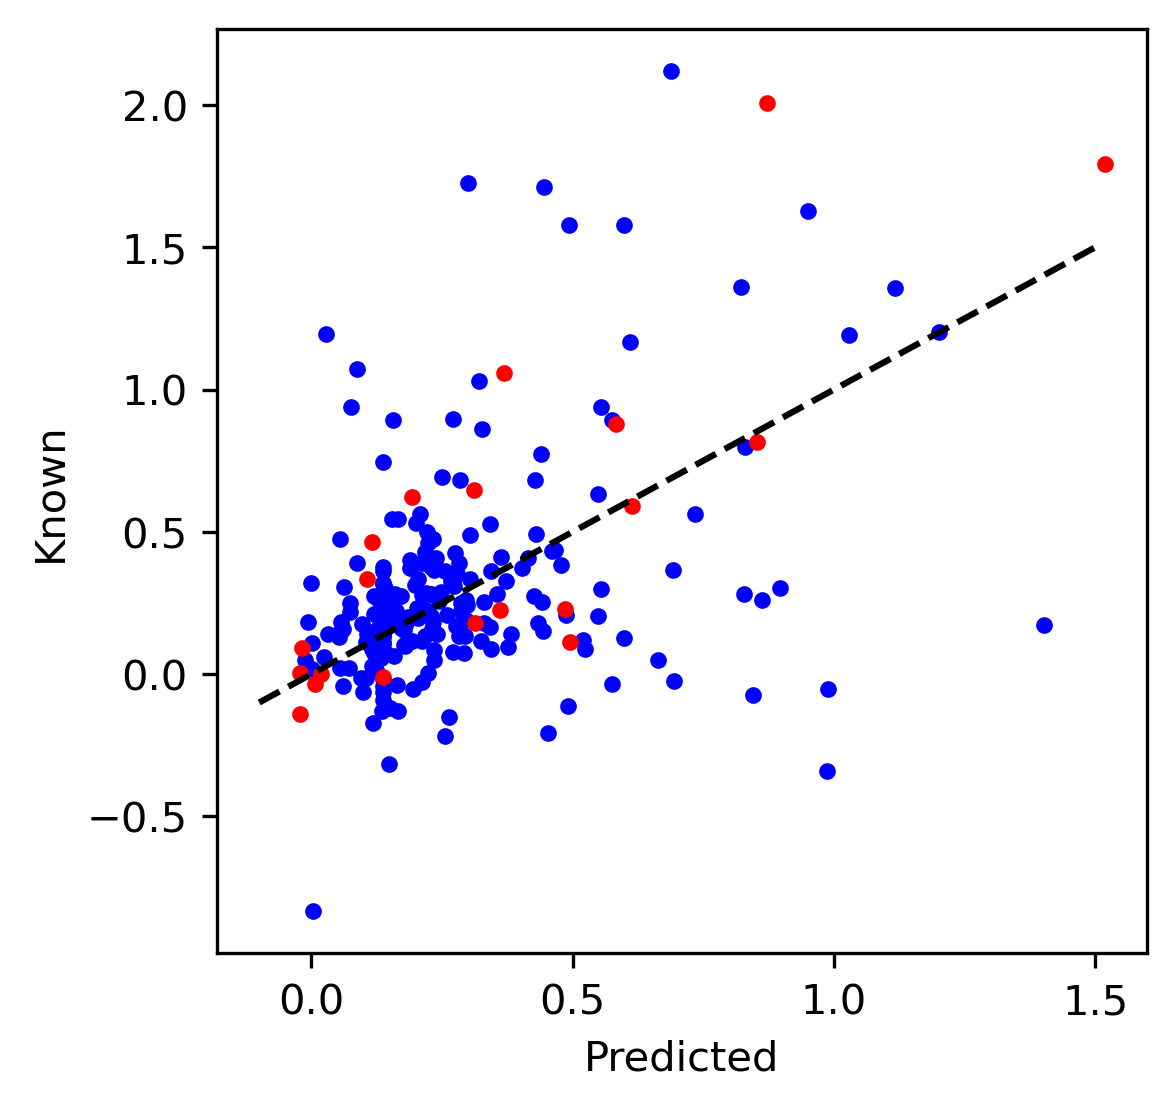

In [9]:
plt.figure(dpi=300, figsize=(4,4))
plt.plot(Y_pred[~test_inDAG], Y_test[~test_inDAG], "b.")
plt.plot(Y_pred[test_inDAG], Y_test[test_inDAG], "r.")
plt.plot([-0.1, 1.5], [-0.1, 1.5], "--", color="blacK")
plt.xlabel("Predicted")
plt.ylabel("Known")
plt.savefig("./S5_scatter.pdf", dpi='figure', bbox_inches='tight')

In [12]:
pearsonr(Y_pred, Y_test)

PearsonRResult(statistic=0.45313152407971136, pvalue=3.7932440665203796e-13)

In [11]:
pearsonr(Y_pred[test_inDAG], Y_test[test_inDAG])

PearsonRResult(statistic=0.8162696588883634, pvalue=1.1385951855313792e-05)